# Zadanie 1

In [1]:
import numpy as np
import time
import cupy as cp

In [2]:
def cpu_matrix_multiply(N):
    A = np.random.rand(N, N).astype(np.float32)
    B = np.random.rand(N, N).astype(np.float32)

    start = time.time()
    C = np.matmul(A, B)
    end = time.time()
    return end - start

N = 1024
result = cpu_matrix_multiply(N)
print(f"Mnożenie macierzy {N}x{N} zakończone w {result:.5f} sekund.")

Mnożenie macierzy 1024x1024 zakończone w 0.02230 sekund.


In [ ]:
import cupy as cp
# cp.get_default_memory_pool().free_all_blocks()

def cupy_matrix_multiply(N):
  A_cpu = np.random.rand(N, N).astype(np.float32)
  B_cpu = np.random.rand(N, N).astype(np.float32)

  A_gpu = cp.array(A_cpu) # kopiowanie danych do gpu
  B_gpu = cp.array(B_cpu)

  start = time.time()
  C_gpu = cp.matmul(A_gpu, B_gpu)
  cp.cuda.Stream.null.synchronize() # zmusza CPU, żeby poczekało, aż GPU skończy
  end = time.time()

  return end - start

N = 1024
result = cupy_matrix_multiply(N)
print(f"Mnożenie macierzy na GPU trwało: {result:.5f} sekund.")

Mnożenie macierzy na GPU trwało: 0.06891 sekund.


In [4]:
matrix_sizes = [128, 256, 512, 1024]
cupy_times = []
for N in matrix_sizes:
  result = cupy_matrix_multiply(N)
  cupy_times.append(result)
  print(f"Mnożenie macierzy {N}x{N} zakończone w {result:.5f} sekund.\n")

print(cupy_times)


Mnożenie macierzy 128x128 zakończone w 0.00041 sekund.

Mnożenie macierzy 256x256 zakończone w 0.00351 sekund.

Mnożenie macierzy 512x512 zakończone w 0.00046 sekund.

Mnożenie macierzy 1024x1024 zakończone w 0.00126 sekund.

[0.00040912628173828125, 0.0035147666931152344, 0.0004596710205078125, 0.001260519027709961]


# Zadanie 2

In [5]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install pycuda

In [6]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

def gpu_matrix_multiply(N: int) -> float:

    kernel_code = """
    __global__ void matrixMul(float *A, float *B, float *C, int N) {
        int row = blockIdx.y * blockDim.y + threadIdx.y;
        int col = blockIdx.x * blockDim.x + threadIdx.x;
        float sum = 0.0;
        if (row < N && col < N) {
            for (int k = 0; k < N; k++) {
                sum += A[row * N + k] * B[k * N + col];
            }
            C[row * N + col] = sum;
        }
    }
    """

    # Kompilacja kernela
    mod = SourceModule(kernel_code)
    matrixMul = mod.get_function("matrixMul")

    A_cpu = np.random.rand(N, N).astype(np.float32)
    B_cpu = np.random.rand(N, N).astype(np.float32)
    C_cpu = np.empty((N, N), np.float32) # pusta macierz wynikowa

    # Alokacja pamięci na GPU
    A_gpu = cuda.mem_alloc(A_cpu.nbytes)
    B_gpu = cuda.mem_alloc(B_cpu.nbytes)
    C_gpu = cuda.mem_alloc(C_cpu.nbytes)

    # Przesłanie danych na GPU
    cuda.memcpy_htod(A_gpu, A_cpu)
    cuda.memcpy_htod(B_gpu, B_cpu)

    # Definiowanie rozmiaru bloku
    block_size = (32, 32, 1)

    # Definiowanie rozmiaru siatki
    grid_size = (int(N / 32), int(N / 32), 1)

    start = time.time()

    # Uruchamianie kernela CUDA
    matrixMul(A_gpu, B_gpu, C_gpu, np.int32(N), block=block_size, grid=grid_size)

    # Synchronizacja z GPU
    cuda.Context.synchronize()
    end = time.time()

    # Pobranie danych z GPU
    cuda.memcpy_dtoh(C_cpu, C_gpu)

    # wyczyścić pamięć karty graficznej
    del A_gpu
    del B_gpu
    del C_gpu

    return end - start

N = 1024
result = gpu_matrix_multiply(N)
print(f"Mnożenie macierzy {N}x{N} zakończone w {result:.5f} sekund.")


Mnożenie macierzy 1024x1024 zakończone w 0.00723 sekund.


# Zadanie 3

Test dla macierzy 128x128
CPU: 0.00067s, GPU: 0.00012s

Test dla macierzy 256x256
CPU: 0.00047s, GPU: 0.00019s

Test dla macierzy 512x512
CPU: 0.00224s, GPU: 0.00098s

Test dla macierzy 1024x1024
CPU: 0.01790s, GPU: 0.00684s



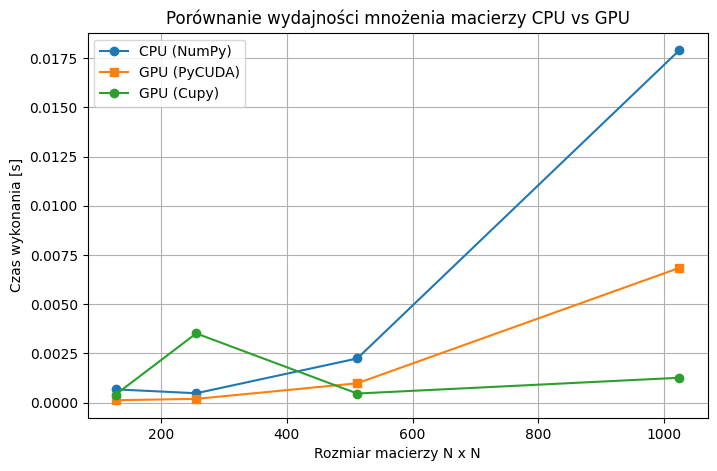

In [8]:
import matplotlib.pyplot as plt

cpu_times = []
gpu_times = []

for N in matrix_sizes:
    print(f"Test dla macierzy {N}x{N}")

    t_cpu = cpu_matrix_multiply(N)

    t_gpu = gpu_matrix_multiply(N)

    cpu_times.append(t_cpu)
    gpu_times.append(t_gpu)

    print(f"CPU: {t_cpu:.5f}s, GPU: {t_gpu:.5f}s\n")

plt.figure(figsize=(8,5))
plt.plot(matrix_sizes, cpu_times, 'o-', label='CPU (NumPy)')
plt.plot(matrix_sizes, gpu_times, 's-', label='GPU (PyCUDA)')
plt.plot(matrix_sizes, cupy_times, 'o-', label='GPU (Cupy)')
plt.xlabel('Rozmiar macierzy N x N')
plt.ylabel('Czas wykonania [s]')
plt.title('Porównanie wydajności mnożenia macierzy CPU vs GPU')
plt.grid(True)
plt.legend()
plt.show()